## Binary classification tutorial
### LOS / NLOS classification 

This is a binary classification tutorial for beginners.  
Our goal is to classify whether UWB samples were collected in LOS or NLOS environments.

#### 1. Dataset
First, lets load all the dataset files from the dataset directory.

In [2]:
import pandas as pd
import glob

files = glob.glob('./dataset/*.csv')
print('Files in dataset directory:\n', files)
datasets = []
for file in files:
    dataset = pd.read_csv(file)
    datasets.append(dataset)
raw_dataset = pd.concat(datasets)

Files in dataset directory:
 ['./dataset/uwb_dataset_part6.csv', './dataset/uwb_dataset_part3.csv', './dataset/uwb_dataset_part1.csv', './dataset/uwb_dataset_part7.csv', './dataset/uwb_dataset_part2.csv', './dataset/uwb_dataset_part5.csv', './dataset/uwb_dataset_part4.csv']


Then let's take a quick skim through the data set

In [3]:
raw_dataset.shape

(42000, 1031)

There are 42000 samples with 1031 columns.  
What columns does it has?

In [4]:
raw_dataset.columns # all the columns

Index(['NLOS', 'RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
       'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC',
       ...
       'CIR1006', 'CIR1007', 'CIR1008', 'CIR1009', 'CIR1010', 'CIR1011',
       'CIR1012', 'CIR1013', 'CIR1014', 'CIR1015'],
      dtype='object', length=1031)

In [5]:
raw_dataset.columns[:20] # first 20 columns

Index(['NLOS', 'RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
       'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC', 'CH', 'FRAME_LEN',
       'PREAM_LEN', 'BITRATE', 'PRFR', 'CIR0', 'CIR1', 'CIR2', 'CIR3', 'CIR4'],
      dtype='object')

So, it has a NLOS column that indicates the sample is NLOS sample, measured range, ..., and extras.  
But it's hard to know the details about the columns.  
Please refer to https://github.com/ewine-project/UWB-LOS-NLOS-Data-Set to know more about the dataset [1].  

In breif, the samples were gathered in 7 different indoor environments using DecaWave DWM1000 UWB radio module.  
In each environment, 3000 LOS samples and 3000 NLOS samples were gathered, so there are 42000 samples.  

Elements:  
NLOS: 1 if NLOS, 0 if LOS  
RANGE: Measured range  
FP_IDX: Index of detected first path  
FP_AMP1: Point 1 of the first path amplitude  
FP_AMP2: Point 2 of the first path amplitude  
FP_AMP3: Point 3 of the first path amplitude  
STDEV_NOISE: Standard deviation of noise  
CIR_PWR: Total channel impluse response (CIR) power  
MAX_NOISE: Maximum value of noise  
RXPACC: Received rx preamble symbols  
CH: channel number  
FRAME_LEN: Length of the frame  
PREAM_LEN: Lenght of the preamble  
BITRATE: Bit rate (Kbps?)  
PRFR: Pulse repetition frequency rate in MHz  
CIR[0~1025]:Absolute value of channel impulse response 

Let's take a look 5 samples from the raw dataset and check the values up to the PRFR columns (exclude CIR)

In [6]:
import numpy as np
np.random.seed(302) # setting random seed for the reproducibility

raw_dataset.sample(5).iloc[:, :15]

,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,CH,FRAME_LEN,PREAM_LEN,BITRATE,PRFR
4677,1.0,5.54,747.0,935.0,3383.0,3804.0,72.0,1014.0,1087.0,1024.0,2.0,39.0,1024.0,110.0,64.0
3930,1.0,3.38,744.0,4036.0,4193.0,4191.0,80.0,3921.0,1185.0,1024.0,2.0,39.0,1024.0,110.0,64.0
1463,0.0,1.26,747.0,16804.0,18246.0,14356.0,68.0,10361.0,1748.0,272.0,2.0,39.0,1024.0,110.0,64.0
5579,0.0,0.96,748.0,17425.0,17411.0,14945.0,100.0,9426.0,2498.0,261.0,2.0,27.0,1024.0,110.0,64.0
902,1.0,2.33,748.0,6642.0,9475.0,11896.0,96.0,4695.0,1434.0,1024.0,2.0,39.0,1024.0,110.0,64.0


We can check dataset's statistics easily by using pandas describe method

In [7]:
raw_dataset.describe().iloc[:, 1:15]

,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,CH,FRAME_LEN,PREAM_LEN,BITRATE,PRFR
count,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.0,42000.000000,42000.000000,42000.0,42000.0
mean,3.831519,745.654167,8127.521905,11425.259524,9738.106048,72.284571,9789.690214,1316.096524,616.27250,2.0,33.801762,1042.980571,110.0,64.0
std,2.355976,4.505024,5393.330697,6235.434769,5352.311549,29.318995,4912.556005,582.434989,306.78537,0.0,5.946221,96.736825,0.0,0.0
min,0.000000,707.000000,7.000000,63.000000,187.000000,28.000000,0.000000,310.000000,128.00000,2.0,27.000000,1024.000000,110.0,64.0
25%,1.810000,744.000000,3573.750000,5322.750000,4723.000000,56.000000,6727.000000,961.000000,318.00000,2.0,27.000000,1024.000000,110.0,64.0
50%,3.480000,746.000000,7140.000000,12318.000000,10262.000000,68.000000,9950.500000,1134.000000,513.00000,2.0,39.000000,1024.000000,110.0,64.0
75%,5.420000,748.000000,12273.000000,17310.000000,14256.000000,80.000000,12443.000000,1488.000000,1024.00000,2.0,39.000000,1024.000000,110.0,64.0
max,28.020000,848.000000,20572.000000,20624.000000,20577.000000,324.000000,37208.000000,5169.000000,1056.00000,2.0,39.000000,1536.000000,110.0,64.0


It seems that FP_AMP2 is highset values among FP_AMP 1, 2, 3 and features about amplitude have high standard deviation.  
Also, some features like CH and BITRATE seem useless, because all samples have same value of these features.    
Interestingly, it seems like most of the FRAME_LEN and PREAM_LEN values are same while there seem to be a few exceptional values.  

Let's examine how many unique values each feature has

In [8]:
raw_dataset.nunique()[:15]

NLOS               2
RANGE           1160
FP_IDX            76
FP_AMP1        16693
FP_AMP2        16533
FP_AMP3        16614
STDEV_NOISE       75
CIR_PWR        16591
MAX_NOISE       3056
RXPACC           725
CH                 1
FRAME_LEN          3
PREAM_LEN          2
BITRATE            1
PRFR               1
dtype: int64

CH, BITRATE, and PRFR have only one unique value that we can drop these features from the dataset because they have no useful information  
for distinguishing LOS/NLOS.  

In [9]:
raw_dataset.drop(['CH', 'BITRATE', 'PRFR'], axis=1, inplace=True)

In [10]:
raw_dataset.columns[:15] # we can see there are no CH, BITRATE, and PRFR in the dataset anymore

Index(['NLOS', 'RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
       'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC', 'FRAME_LEN',
       'PREAM_LEN', 'CIR0', 'CIR1', 'CIR2'],
      dtype='object')

Besides, we can see that min value of the CIR_PWR is 0 but it looks like outlier or fault value.

In [11]:
raw_dataset[raw_dataset['CIR_PWR']==0]

,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1006,CIR1007,CIR1008,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015
1356,1.0,6.33,747.0,293.0,311.0,187.0,28.0,0.0,310.0,160.0,...,197.0,84.0,246.0,353.0,196.0,38.0,228.0,42.0,173.0,0.0
4343,1.0,7.02,757.0,30.0,214.0,413.0,36.0,0.0,412.0,192.0,...,252.0,271.0,190.0,292.0,271.0,239.0,210.0,260.0,223.0,256.0
837,1.0,4.88,739.0,112.0,323.0,227.0,40.0,0.0,322.0,128.0,...,161.0,219.0,295.0,242.0,279.0,67.0,153.0,177.0,159.0,0.0


Above result shows that the samples which have 0 CIR_PWR are NLOS.  
We can drop these samples from the dataset, but leave it now for a while for the future analysis.

Let's dive deep into the other features later in the chapter data analysis.

### 2. Baseline

Let's reproduce baseline machine learning model and features in the paper:     
*Ferreira, André G., et al. "Feature selection for real-time NLOS identification and mitigation   
for body-mounted UWB transceivers." IEEE Transactions on Instrumentation and Measurement 70 (2021): 1-10*  [2].

With the baseline, it is easy to compare how new models or features help improve performance.  

The work in [2] use 14 features for the LOS/NLOS classification.  
We can also find 9 features in the dataset [1], but we need to add 5 more features.  
We will just implement 5 features in here without explanation, please refer to [2] who interested about features.

In [12]:
const_A = 121.74

dataset = raw_dataset.copy() # copy raw dataset

# estimated received signal strength
dataset['PWR_RSS'] =  10.0 * np.log10(1+ dataset['CIR_PWR']*pow(2,17) / pow(dataset['RXPACC'], 2)) - const_A 
# estimated received power of the first path impulse
dataset['PWR_FP'] = 10.0 * np.log10(1+ (pow(dataset['FP_AMP1'], 2) + pow(dataset['FP_AMP1'], 2) + pow(dataset['FP_AMP1'], 2))
                                    / pow(dataset['RXPACC'], 2)) - const_A
# ratio of Maximum noise and first path power
dataset['RAT_MN_FP'] = dataset['MAX_NOISE'] / dataset['FP_AMP2']
# power difference between the estimated RSS and estimated power of the first path
dataset['PWR_DIFF'] = dataset['PWR_RSS'] - dataset['PWR_FP']
# power ratio between the estimated power of the first path and estimated RSS
dataset['PWR_RAT'] = dataset['PWR_FP'] / dataset['PWR_RSS']

Next, we will set NLOS column as a target (y) and pull out 14 baseline features from the dataset and split the dataset into train and test data.

In [13]:
from sklearn.model_selection import train_test_split

baseline_features_14 = ['RANGE', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3', 'STDEV_NOISE',
                        'CIR_PWR', 'RXPACC', 'MAX_NOISE', 'FP_IDX',
                        'PWR_RSS', 'PWR_FP', 'RAT_MN_FP', 'PWR_DIFF', 'PWR_RAT']

y = dataset['NLOS']
X = dataset[baseline_features_14]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=302)

In [14]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(33600, 14) (33600,) (8400, 14) (8400,)


Then, let's bulid a random forest classifier model which shows highest f1_score in [2].  
We train the model with the training samples and predict test samples' LOS/NLOS with the trained model.

In [15]:
from sklearn.ensemble import RandomForestClassifier

# same hyperparameters with [2] and set random_state for the reproducibility
baseline14_model = RandomForestClassifier(n_estimators=30, random_state=302)
# training
baseline14_model.fit(train_X, train_y)
# predicts LOS/NLOS using test samples
pred_y = baseline14_model.predict(test_X)

Then let's see f1_score of the baseline model with 14 features.

In [16]:
from sklearn.metrics import f1_score
baseline14_score = f1_score(test_y, pred_y)

print(baseline14_score)

0.9077669902912622


In [2], baseline model shows 0.97 f1 score but the result above shows about 0.9 f1 score.  
I think this performance degradation comes from the various enviromental setting.  
Because dataset [1] collected from 7 indoor environments while dataset in [2] collected from the same environment.

In addition, [2] showed that random forest classifier model which trained with the 4 features ('PWR_DIFF', 'FP_IDX', 'PWR_FP', 'FP_AMP2') achieves   
similar f1_score (0.97) with the model trained with the 14 features.  
So let's test again with the model which trained with the 4 features.

In [17]:
baseline_features_4 = ['PWR_DIFF', 'FP_IDX', 'PWR_FP', 'FP_AMP2']

y = dataset['NLOS']
X = dataset[baseline_features_4]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=302)

baseline4_model = RandomForestClassifier(n_estimators=30, random_state=302)
baseline4_model.fit(train_X, train_y)
pred_y = baseline4_model.predict(test_X)
baseline4_score = f1_score(test_y, pred_y)

print('baseline 4 f1 score:', baseline4_score)
print('baseline 14 f1 score:', baseline14_score)

baseline 4 f1 score: 0.8418316831683167
baseline 14 f1 score: 0.9077669902912622


In [2], where the dataset collected from the same environments, the performance of those two models are almost same.  
But, above result indicates that the 4 useful features are not enough to distinguishing LOS/NLOS in different environments scenarios. 

### 3. Data analysis

In the last section, baseline model showed reasonable performance (0.907 f1 score) with 14 features.  
But how can we know which features are informative and which ones hinder training?  

#### 3-1. Correlation

One of the simplest things is check correlation which shows linear relationship among features.  
We can easily check the correlation using pandas corr method.  
Let's analysis all the available features except CIR [0-1025] features.

In [18]:
# 16 features and 1 target 
features_with_target = ['RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
                        'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC', 'FRAME_LEN',
                        'PREAM_LEN', 'PWR_RSS', 'PWR_FP', 'RAT_MN_FP', 'PWR_DIFF', 'PWR_RAT', 
                        'NLOS']
my_dataset = dataset[features_with_target]

First, let's examine which feature is most correlated with the LOS, NLOS

In [19]:
my_dataset.corr()['NLOS'].sort_values(ascending=False)

NLOS           1.000000
RXPACC         0.730690
RANGE          0.456845
RAT_MN_FP      0.272795
PWR_DIFF       0.255453
PREAM_LEN      0.189658
PWR_RAT        0.183870
STDEV_NOISE    0.152291
FRAME_LEN      0.034316
MAX_NOISE     -0.198198
FP_IDX        -0.316978
CIR_PWR       -0.392303
FP_AMP1       -0.447279
FP_AMP3       -0.514339
FP_AMP2       -0.524905
PWR_FP        -0.608943
PWR_RSS       -0.712536
Name: NLOS, dtype: float64

It seems like features about power are important indicators of the NLOS.  
It shows that samples with low power tends to be NLOS sample.  
Futhermore, NLOS samples have many received rx preamble symbols.  
The code below sort correlation values with absolute values.  

In [20]:
abs(my_dataset.corr()['NLOS']).sort_values(ascending=False)

NLOS           1.000000
RXPACC         0.730690
PWR_RSS        0.712536
PWR_FP         0.608943
FP_AMP2        0.524905
FP_AMP3        0.514339
RANGE          0.456845
FP_AMP1        0.447279
CIR_PWR        0.392303
FP_IDX         0.316978
RAT_MN_FP      0.272795
PWR_DIFF       0.255453
MAX_NOISE      0.198198
PREAM_LEN      0.189658
PWR_RAT        0.183870
STDEV_NOISE    0.152291
FRAME_LEN      0.034316
Name: NLOS, dtype: float64

We can also make a fancy correlation figure with seaborns and matplotlib libraries.

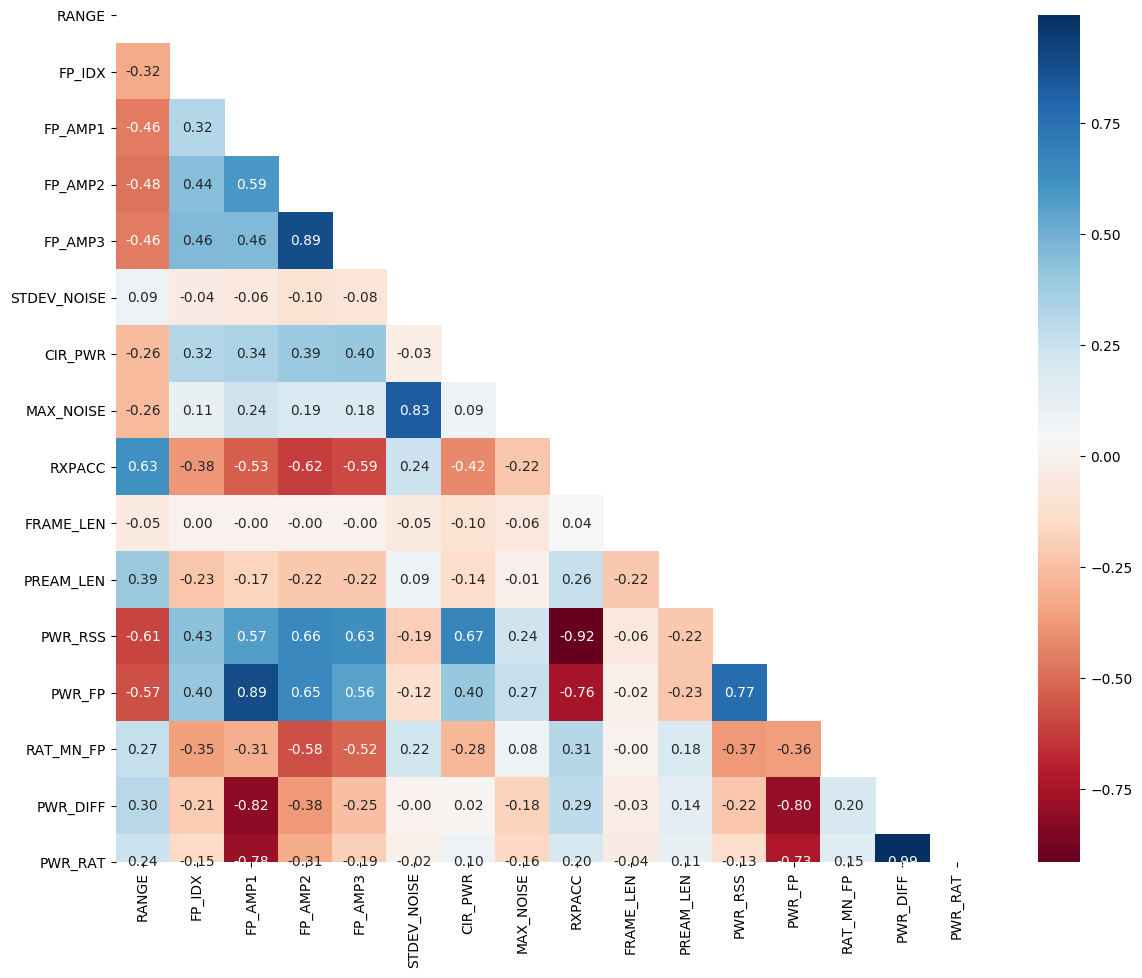

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# mask is optional for removes upper triangle of the plot
mask = np.zeros_like(my_dataset.drop('NLOS', axis=1).corr())
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(14, 11))
sns.heatmap(my_dataset.drop('NLOS', axis=1).corr(),
            annot=True,
            fmt='.2f',
            cmap='RdBu',
            mask=mask)

If we just look at to the correlation values which higher than 0.8 or lower than -0.8, we can list  
FP_AMP3 <-> FP_AMP2: 0.89  
MAX_NOISE <-> STDEV_NOISE: 0.83  
PWR_RSS <-> RXPACC: -0.92  
PWR_FP <-> FP_AMP1: 0.89  
PWR_DIFF <-> FP_AMP1: -0.82  
PWR_DIFF <-> PWR_FP: -0.8  
PWR_RAT <-> PWR_DIFF: 0.99  

The result suggests that PWR_DIFF and FP_AMP1 are informative features.

#### 3-2. Mutual information

Mutual information measure relationship between two quantities.  
While correlation only detects linear relationship, the mutual information can detect both linear and non-linear relationships.  
The least possible value of the mutual information is 0 and it indicates two features are independent.  
In theory, there is no upper bound, but values above 2.0 are uncommon.

Let's get mutual information score using sklearn mutual_info_classif (mutual_info_regression is for the real-value targets).

In [22]:
from sklearn.feature_selection import mutual_info_classif

y = my_dataset['NLOS']
X = my_dataset.drop('NLOS', axis=1)

mi_scores = pd.Series(mutual_info_classif(X, y), index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
corr_scores = abs(my_dataset.corr()['NLOS']).sort_values(ascending=False)[1:] # corr scores
print(mi_scores)

PWR_RSS        0.336761
RXPACC         0.322162
PWR_FP         0.241272
CIR_PWR        0.164926
FP_AMP3        0.155656
FP_AMP2        0.152521
MAX_NOISE      0.140943
RANGE          0.137588
FP_AMP1        0.113366
FP_IDX         0.098724
RAT_MN_FP      0.094321
STDEV_NOISE    0.093132
PWR_DIFF       0.053196
PWR_RAT        0.029342
PREAM_LEN      0.027418
FRAME_LEN      0.005390
dtype: float64


Then print out the mutual information scores and correlation scores in descending order

In [23]:
for mi, corr in zip(mi_scores.index, corr_scores.index):
    print(mi.ljust(13), corr.rjust(13))

PWR_RSS              RXPACC
RXPACC              PWR_RSS
PWR_FP               PWR_FP
CIR_PWR             FP_AMP2
FP_AMP3             FP_AMP3
FP_AMP2               RANGE
MAX_NOISE           FP_AMP1
RANGE               CIR_PWR
FP_AMP1              FP_IDX
FP_IDX            RAT_MN_FP
RAT_MN_FP          PWR_DIFF
STDEV_NOISE       MAX_NOISE
PWR_DIFF          PREAM_LEN
PWR_RAT             PWR_RAT
PREAM_LEN       STDEV_NOISE
FRAME_LEN         FRAME_LEN


Baseline [2] uses 'PWR_DIFF', 'FP_IDX', 'PWR_FP', 'FP_AMP2' as best 4 features.  
But, it looks like there are more useful features we can take advantage of.

Futhermore the feature PREAM_LEN looks interesting because it has low mi_score but while has releatively high corr_score,  
and also it has only 2 unique values as we examined before (1024, 1536).

Let's make a barplot using preamble length and NLOS columns.

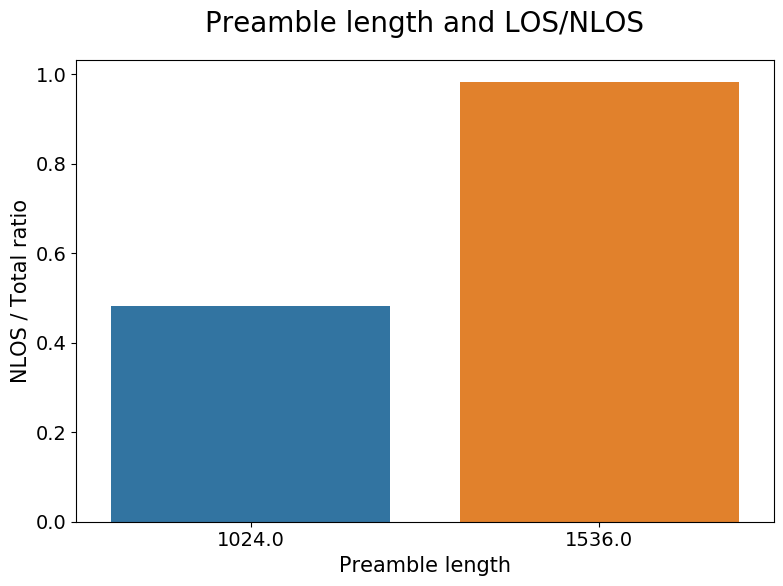

In [24]:
plt.subplots(figsize = (9,6))
sns.barplot(x = "PREAM_LEN", 
            y = "NLOS", 
            data=my_dataset, 
            linewidth=6,
            ci=None,
           )

plt.title("Preamble length and LOS/NLOS", fontsize = 20, pad=20)
plt.xlabel("Preamble length", fontsize = 15)
plt.ylabel("NLOS / Total ratio", fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

It looks really awkward because the graph says almost every samples with 1536 preamble length is NLOS!  
Then how many samples with 1536 preamble length in the dataset?

In [25]:
my_dataset[my_dataset['PREAM_LEN']==1536].shape

(1557, 17)

1557 samples have 1536 preambles. Then how many samples are LOS samples among them?  
We can also utilize query to pandas dataframe.

In [26]:
my_dataset.query("PREAM_LEN==1536 & NLOS==0").shape

(26, 17)

In [27]:
1 - (26/1557)

0.98330122029544

It shows that 98% of the samples with 1536 preamble length are NLOS samples.  
Then how about frame length?

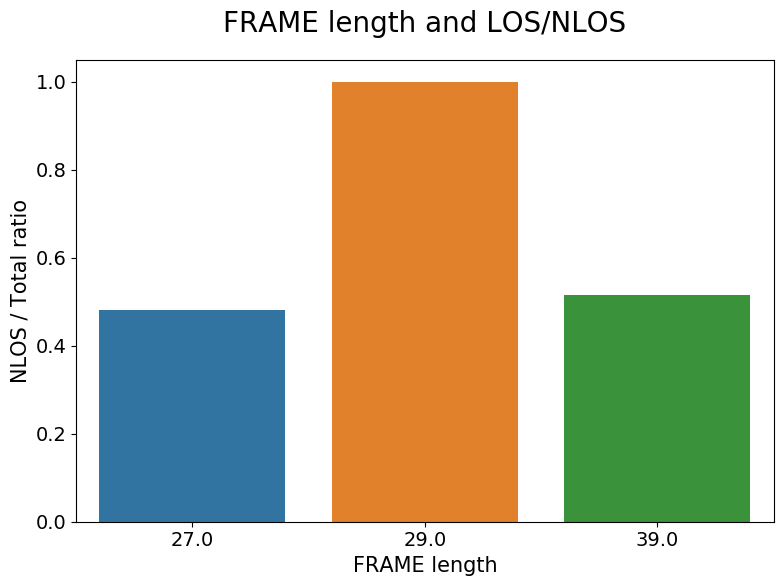

In [28]:
plt.subplots(figsize = (9,6))
sns.barplot(x = "FRAME_LEN", 
            y = "NLOS", 
            data=my_dataset, 
            linewidth=6,
            ci=None,
           )

plt.title("FRAME length and LOS/NLOS", fontsize = 20, pad=20)
plt.xlabel("FRAME length", fontsize = 15)
plt.ylabel("NLOS / Total ratio", fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

It seems like frame length 29 can be a good indicator.
How many samples have 29 frame length?

In [29]:
my_dataset.query("FRAME_LEN==29")

,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,FRAME_LEN,PREAM_LEN,PWR_RSS,PWR_FP,RAT_MN_FP,PWR_DIFF,PWR_RAT,NLOS
3932,9.08,744.0,1666.0,2987.0,3825.0,52.0,851.0,772.0,364.0,29.0,1024.0,-92.482477,-103.688753,0.258453,11.206276,1.121172,1.0


There is just one sample.  
We can discard FRAME_LEN feature because it has no useful information

In [30]:
my_dataset.drop(['FRAME_LEN'], axis=1, inplace=True)

/home/jyeom/anaconda3/envs/py37tf26/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### 3-3. Permutation importance

Naturally, we are curious about the question *how much does each feature affect the model prediction?*  
Permutation importance randomly shuffle a single feature at a time, make a prediction with a trained model and then measures the performance.  
If the shuffled feature is important then the prediction performance will be poor, otherwise the performance will be similar.  

Permutation importance is fast to calculate and easy to understand.  
We can leverage eli5 library to calulate the permutation importance.

In [107]:
# !pip install eli5
import eli5
# first we need a pretrained model with considered features
y = my_dataset['NLOS']
X = my_dataset.drop(['NLOS'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=302)

my_model = RandomForestClassifier(n_estimators=30, random_state=302)
my_model.fit(train_X, train_y)

# Then calculates permutation importance with the trained model and not observed data
perm = eli5.sklearn.PermutationImportance(my_model, random_state=302).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=test_X.columns.to_list())

Weight,Feature
0.1955 ± 0.0076,PWR_RSS
0.0961 ± 0.0029,RANGE
0.0362 ± 0.0022,RXPACC
0.0187 ± 0.0029,CIR_PWR
0.0040 ± 0.0030,FP_AMP3
0.0037 ± 0.0025,MAX_NOISE
0.0035 ± 0.0017,RAT_MN_FP
0.0035 ± 0.0017,PWR_FP
0.0021 ± 0.0015,FP_AMP2
0.0018 ± 0.0016,LOG_MAX_NOISE


We can interpret the first number in each weight as performace degradation after the feature shuffle,   
and second number after +- sign as error because we evaluate each feature several times for validation.  
Above table shows that 'PWR_RSS', 'RANGE', 'RXPACC', 'CIR_PWR', 'PWR_FP' and 'MAX_NOISE' have significant weights.

#### 3-4. Shap value

When we want to know how the model works for predictions, Shap values interpret the impact of features on the prediction.  
For example, When the 'PWR_RSS' value is high, does the model predict NLOS or LOS for this sample? If Los, How confident is the model about the prediction?  
We can answer these questions by interpreting shap values.

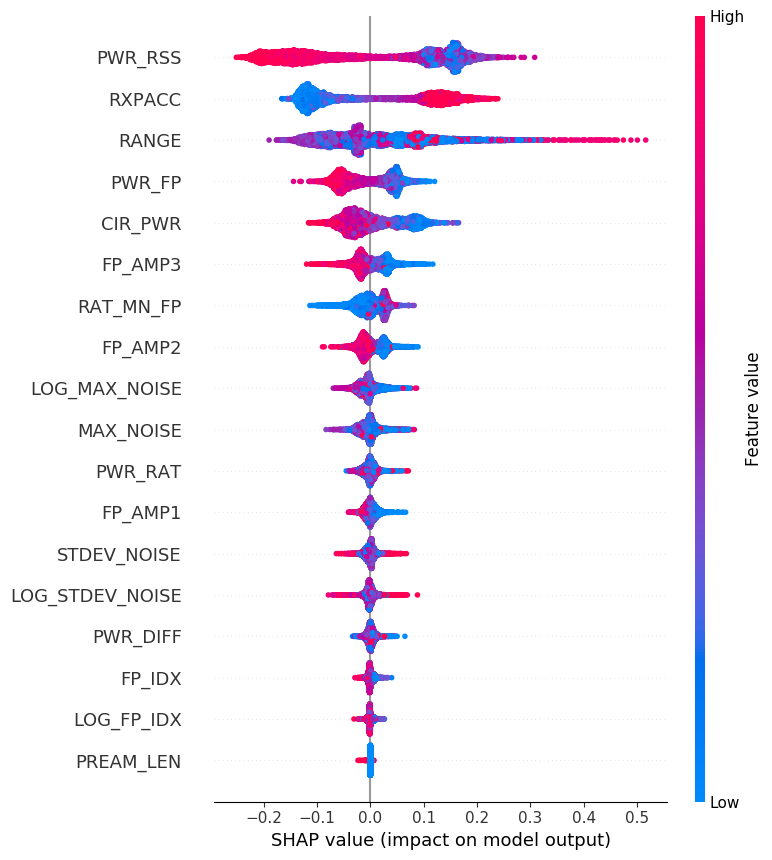

In [110]:
# !pip install git+https://github.com/slundberg/shap.git 
import shap  # package used to calculate Shap values

# Calculate shap values for all of test_X, it takes long time (about 4 minutes in Ryzen5700 CPU)
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(test_X)

# Make plot
shap.summary_plot(shap_values[1], test_X)

Above figure shows that when the value of 'PWR_RSS' is high, the model tends to predict this sample as LOS.  
Contrary, when the value of 'RANGE' is high, the model tends to predict this sample as NLOS.  

However, high "MAX_NOISE' values have both positive and negative effects on the prediction.   
It suggests that 'MAX_NOISE' is interacting with other feature, but we don't know yet what other feature is interacting with 'STD_DEV'.

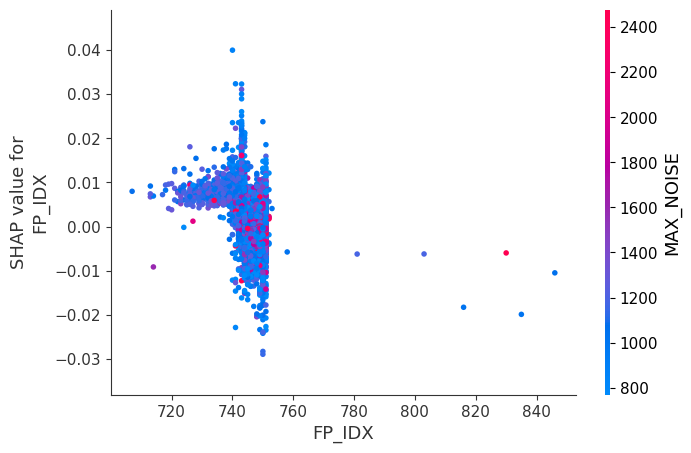

In [141]:
shap.dependence_plot('FP_IDX', shap_values[1], test_X, interaction_index='MAX_NOISE')

In [144]:
my_features_4 = ['PWR_RSS', 'RXPACC', 'RANGE', 'MAX_NOISE']  

y = my_dataset['NLOS']
X = my_dataset[my_features_4]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=302)
my_model_4 = RandomForestClassifier(n_estimators=30, random_state=302)
my_model_4.fit(train_X, train_y)
pred_y = my_model_4.predict(test_X)
score = f1_score(test_y, pred_y)

print('my score:', score, '\nbaseline4_score:', baseline4_score, '\nbaseline14_score', baseline14_score)

my score: 0.8975998070196598 
baseline4_score: 0.8418316831683167 
baseline14_score 0.9077669902912622



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'FP_IDX and LOS/NLOS')

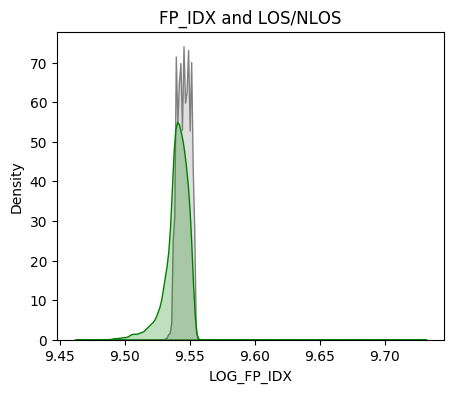

In [98]:
my_dataset['LOG_MAX_NOISE'] = my_dataset['MAX_NOISE'].apply(np.log10) 
fig = plt.figure(figsize=(5,4),)
ax=sns.kdeplot(my_dataset.loc[(my_dataset['NLOS'] == 0),'LOG_FP_IDX'] , color='gray',shade=True,label='not survived')
ax=sns.kdeplot(my_dataset.loc[(my_dataset['NLOS'] == 1),'LOG_FP_IDX'] , color='g',shade=True, label='survived')
plt.title('FP_IDX and LOS/NLOS')

my score: 0.8975998070196598 
baseline4_score: 0.8418316831683167 
baseline14_score 0.9077669902912622


In [67]:
train_X = train_X[features]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
my_dataset['LOG_STDEV_NOISE'] = my_dataset['STDEV_NOISE'].apply(np.log10) 
sns.kdeplot(my_dataset.LOG_MAX_NOISE, shade=True, ax=axs[0])
sns.kdeplot(my_dataset.MAX_NOISE, shade=True, ax=axs[1]);